### **Imports**

In [59]:
from utils import visualise_gridsearch, print_top_predictions, make_top_10

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### **Data setup**

In [60]:
df = pd.read_csv('data/OnlineNewsPopularity.csv')
df = df.rename(columns=lambda x: x.strip())
y_raw = df['shares']

POPULARITY_SPLIT = 0.9

high_thresh = y_raw.quantile(POPULARITY_SPLIT)
y_class = (y_raw >= high_thresh).astype(int)

print("Class distribution:")
print(y_class.value_counts())

df_sorted = df.copy().sort_values('timedelta', ascending=False)

TRAIN_SPLIT = 0.85
train_size = int(len(df_sorted) * TRAIN_SPLIT)

train_df = df_sorted.iloc[:train_size]
test_df = df_sorted.iloc[train_size:]

X_train = train_df.drop(columns=['url', 'timedelta', 'shares'])
y_train_class = (train_df['shares'] >= high_thresh).astype(int)
y_train_reg_log = np.log1p(train_df['shares'])

X_test_full = test_df.drop(columns=['url', 'timedelta', 'shares'])
y_test_full_class = (test_df['shares'] >= high_thresh).astype(int)
y_test_full_reg_log = np.log1p(test_df['shares'])

test_splits = np.array_split(test_df, 3)

X_test_sets = []
y_test_sets_class = []
y_test_sets_reg_log = []

for ts in test_splits:
    X_test_sets.append(ts.drop(columns=['url', 'timedelta', 'shares']))
    y_test_sets_class.append((ts['shares'] >= high_thresh).astype(int))
    y_test_sets_reg_log.append(np.log1p(ts['shares']))

Class distribution:
shares
0    35615
1     4029
Name: count, dtype: int64


In [61]:
''' 2 available splitting types, TimeSeries overall gets better results '''

# cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv = TimeSeriesSplit(n_splits=3)

### **Baseline classifier** 

In [62]:
standard_pipeline = SkPipeline([
    ("xgb", XGBClassifier(
        objective="rank:pairwise",
        eval_metric="ndcg",
        random_state=42,
    ))
])

standard_param_grid = {
    "xgb__n_estimators": [50, 100, 150],
    "xgb__learning_rate": [0.05, 0.1, 0.15],
    "xgb__max_depth": [7, 9, 11],
}

standard_grid = GridSearchCV(
    estimator=standard_pipeline,
    param_grid=standard_param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n=== Running GridSearchCV ===")
standard_grid.fit(X_train, y_train_class)
print("\nBest parameters:", standard_grid.best_params_)
print("Best CV score:", round(standard_grid.best_score_, 3))


=== Running GridSearchCV ===
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 9, 'xgb__n_estimators': 100}
Best CV score: 0.189


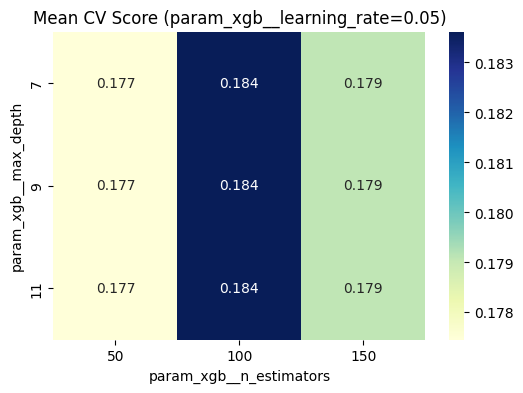

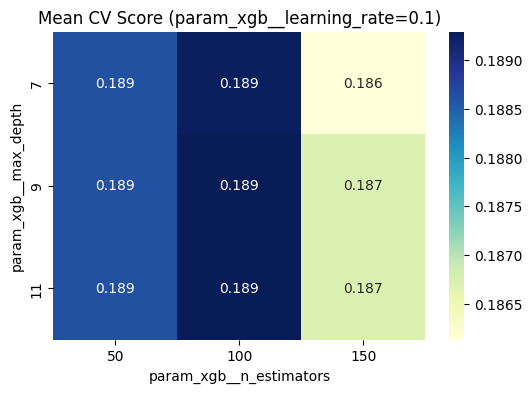

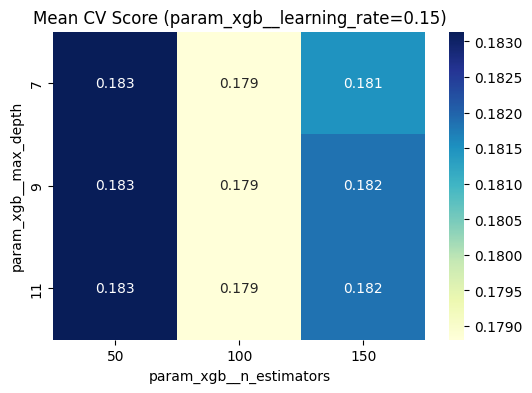

In [63]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(standard_grid.cv_results_), 
                     'param_xgb__max_depth', 'param_xgb__n_estimators', 'param_xgb__learning_rate')

In [64]:
best_model = standard_grid.best_estimator_

top10_list = make_top_10(best_model, X_test_sets, y_test_sets_class)
print_top_predictions(top10_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)


=== TOP 10 (Test Set 1) ===
   true_label     score
0           1  1.146520
1           0  0.775102
2           1  0.524850
3           0  0.308950
4           0 -0.019086
5           0 -0.026452
6           0 -0.044618
7           0 -0.092887
8           0 -0.278212
9           0 -0.301992
Hits @10: 2

=== TOP 10 (Test Set 2) ===
   true_label     score
0           0  1.969421
1           0  0.898085
2           0  0.888726
3           0  0.624501
4           1  0.522385
5           0  0.292299
6           0  0.210472
7           0  0.053003
8           0  0.009101
9           0 -0.063386
Hits @10: 1

=== TOP 10 (Test Set 3) ===
   true_label     score
0           1  0.967405
1           0  0.963117
2           0  0.879975
3           0  0.750173
4           1  0.712155
5           0  0.472997
6           0  0.381772
7           0  0.156371
8           0  0.010568
9           0 -0.002222
Hits @10: 2


### **SMOTE classifier**

In [76]:
smote_pipeline = ImbPipeline([
    ("resample", SMOTETomek(sampling_strategy=0.3, random_state=42)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

smote_param_grid = {
    "xgb__n_estimators": [100, 300, 500, 750],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [1, 3, 5, 7],
}

smote_grid = GridSearchCV(
    estimator=smote_pipeline,
    param_grid=smote_param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n=== Running GridSearchCV ===")
smote_grid.fit(X_train, y_train_class)
print("\nBest parameters:", smote_grid.best_params_)
print("Best CV score:", round(smote_grid.best_score_, 3))


=== Running GridSearchCV ===
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 500}
Best CV score: 0.219


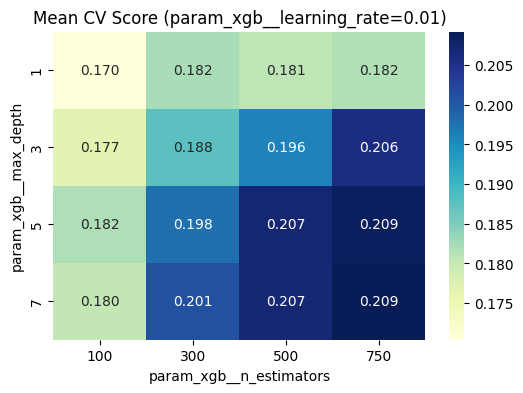

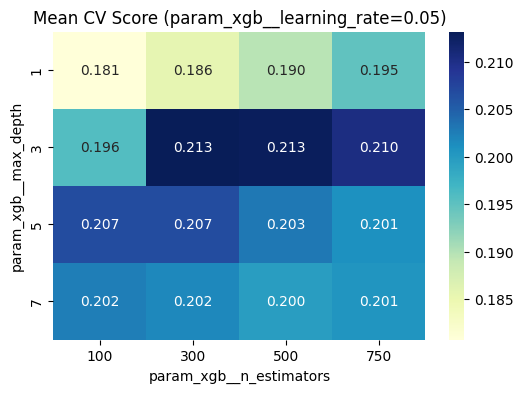

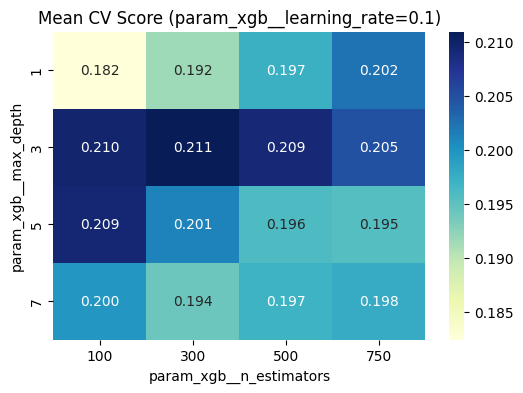

In [66]:
visualise_gridsearch(pd.DataFrame(smote_grid.cv_results_),
                     'param_xgb__max_depth', 'param_xgb__n_estimators', 'param_xgb__learning_rate')

In [78]:
best_model = smote_grid.best_estimator_

top10_list = make_top_10(best_model, X_test_sets, y_test_sets_class)
print_top_predictions(top10_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)


=== TOP 10 (Test Set 1) ===
   true_label     score
0           0  0.526804
1           0  0.510061
2           0  0.457534
3           1  0.443965
4           1  0.434132
5           0  0.425230
6           1  0.420237
7           0  0.418046
8           1  0.413283
9           1  0.413030
Hits @10: 5

=== TOP 10 (Test Set 2) ===
   true_label     score
0           1  0.547381
1           0  0.478013
2           0  0.473524
3           0  0.459029
4           0  0.441343
5           0  0.422240
6           0  0.420006
7           0  0.419944
8           1  0.409093
9           0  0.405512
Hits @10: 2

=== TOP 10 (Test Set 3) ===
   true_label     score
0           0  0.712854
1           0  0.521618
2           1  0.462965
3           1  0.457200
4           1  0.444857
5           0  0.423568
6           0  0.406658
7           0  0.401018
8           1  0.395571
9           0  0.395148
Hits @10: 4


### **Regression**

In [68]:
reg_pipeline = ImbPipeline([
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

reg_param_grid = {
    "xgb__n_estimators": [50, 100, 300, 500],
    "xgb__learning_rate": [0.01, 0.05, 0.1],
    "xgb__max_depth": [1, 3, 5, 7],
}

reg_grid = GridSearchCV(
    estimator=reg_pipeline,
    param_grid=reg_param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n=== Running GridSearchCV for XGBRegressor ===")
reg_grid.fit(X_train, y_train_reg_log)
print("\nBest parameters:", reg_grid.best_params_)
print("Best CV score:", round(reg_grid.best_score_, 3))


=== Running GridSearchCV for XGBRegressor ===
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 300}
Best CV score: 0.143


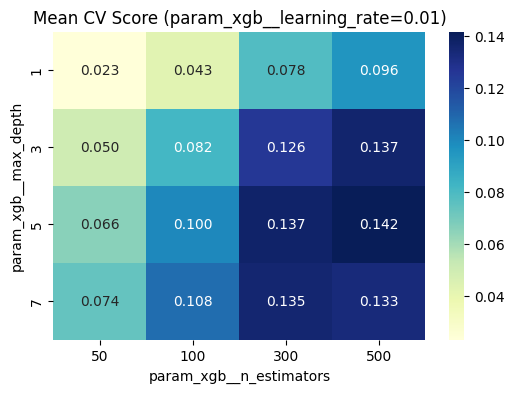

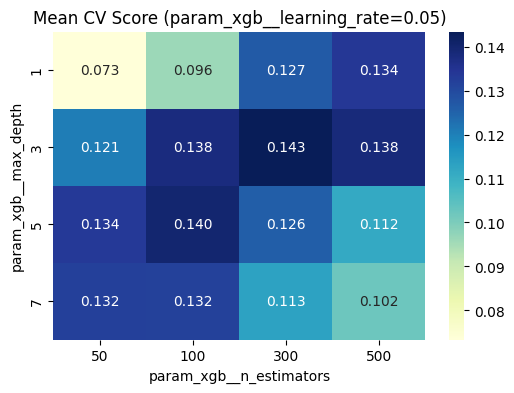

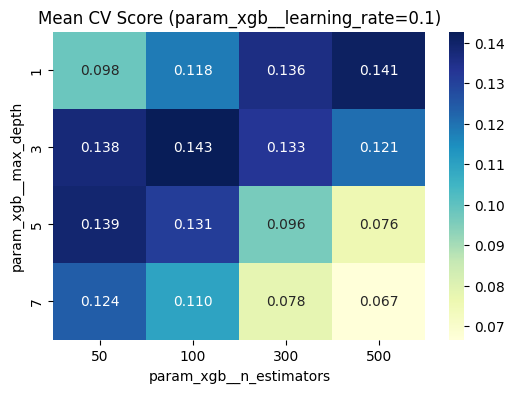

In [69]:
# cv_results_df = pd.DataFrame(standard_grid.cv_results_)
# print(cv_results_df.columns)

visualise_gridsearch(pd.DataFrame(reg_grid.cv_results_), 
                     'param_xgb__max_depth', 'param_xgb__n_estimators', 'param_xgb__learning_rate')

In [70]:
best_model = reg_grid.best_estimator_

top10_list = make_top_10(best_model, X_test_sets, y_test_sets_class, regression=True)
print_top_predictions(top10_list, X_test_sets, y_test_sets_class, y_test_sets_reg_log)


=== TOP 10 (Test Set 1) ===
   true_label     score
0           0  8.704374
1           1  8.528666
2           0  8.527376
3           1  8.514830
4           0  8.509332
5           1  8.481306
6           1  8.469011
7           1  8.461287
8           0  8.452240
9           0  8.450851
Hits @10: 5

=== TOP 10 (Test Set 2) ===
   true_label     score
0           0  8.493220
1           0  8.482081
2           1  8.469756
3           1  8.468257
4           0  8.443521
5           1  8.429325
6           0  8.420904
7           0  8.411242
8           0  8.405127
9           0  8.400692
Hits @10: 3

=== TOP 10 (Test Set 3) ===
   true_label     score
0           0  8.999578
1           0  8.690572
2           0  8.682429
3           1  8.605136
4           0  8.593383
5           0  8.537610
6           1  8.445823
7           0  8.424509
8           0  8.388194
9           0  8.386713
Hits @10: 2
